In [74]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import prepare_data as prep_data
from sklearn.cluster import AgglomerativeClustering
%matplotlib notebook

In [2]:
df = prep_data.open_data("dataset.pkl")

In [3]:
malware_families = { 'Empty': -1, 'Shohdi':0, 'Bublik':1, 'Mira':2, 'spyeye':3, 'Njrat':4, 'Shifu':5, 'sakula_v1_3':6,
 'Wabot':7, 'Warp':8, 'Nanocore_RAT_Gen_2':9, 'Wimmie':10, 'xRAT':11}
inv_malware_fam = {v: k for k, v in malware_families.items()}

In [4]:
tmp = df
tmp['tag'] = -1
for i, row in df.iterrows():
    for yara_rule in row['yara']:
        if yara_rule in malware_families:
            tmp['tag'][i] = malware_families[yara_rule]
            break

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
groups = {}
for i in range(-1,12):
    group_rows = tmp[tmp['tag'] == i]
    groups[inv_malware_fam[i]] =  group_rows.index
tmp['tag'] = tmp['tag'].apply(lambda x: inv_malware_fam[x])

# Prepare the yara column

In [6]:
df_yara = pd.DataFrame(df['yara'])
su_list = prep_data.get_unique_values(df, 'yara')
for colname in su_list:
    df_yara[colname] = 0
df1 = prep_data.fill_up_the_relevance_table(df_yara, set(su_list), 'yara')

# Automatized clustering search

In [7]:
def automated_cluster_search():
    shortlengths = range(2,5)
    longlengths = range(12,23, 2)
    countofSamples_whichcontains_string = range(13,22)
    kmeans_ncluster = range(4,12)
    dbscan_eps = range(1, 24, 3)
    spectral_ncluster = range(4,12)

    df = prep_data.open_data("dataset.pkl")
    tmp = df.copy()
    tmp['tag'] = -1
    for i, row in df.iterrows():
        for yara_rule in row['yara']:
            if yara_rule in malware_families:
                tmp['tag'][i] = malware_families[yara_rule]
                break
    groups = {}
    for i in range(-1,12):
        group_rows = tmp[tmp['tag'] == i]
        groups[inv_malware_fam[i]] =  group_rows.index
    tmp['tag'] = tmp['tag'].apply(lambda x: inv_malware_fam[x])

    for shortlen in shortlengths:
        for longlen in longlengths:
            for countsamplelen in countofSamples_whichcontains_string:

                df1 = prep_data.prepare_string_column(df, shortlen,longlen, countsamplelen)
                res_1 = df1.iloc[:,1:]
                #pca = PCA(n_components=5)
                #res = pca.fit_transform(res_1)
                res = res_1

                for kmean, dbscan, spectral in zip(kmeans_ncluster, dbscan_eps, spectral_ncluster):
                    filepath = 'result/' + 'short' + str(shortlen) + '_long' + str(longlen) + '_count' + str(countsamplelen) + '_kmean' + str(kmean) + '_dbscan' + str(dbscan) + '_spectral' + str(spectral)
                    print(filepath)
                    prep_data.mkdir_p(filepath)
                    do_some_cluster(filepath, res,tmp, kmean, dbscan, spectral)

In [8]:
def do_some_cluster(filepath, res,tmp,  kmean_ncluster = 8, dbscan_eps = 10, spectral_ncluster = 8):
    kmeans = KMeans(n_clusters=kmean_ncluster, init='k-means++', max_iter=400, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(res)

    clustering = DBSCAN(dbscan_eps, min_samples=5)
    pred_y2 = clustering.fit_predict(res)
    dbscan_ncluster = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)

    spectral = SpectralClustering(spectral_ncluster, eigen_solver='arpack', affinity="nearest_neighbors")
    pred_y3 = spectral.fit_predict(res)
    
    try:
        prep_data.check_result(res, pred_y)
        prep_data.check_result(res, pred_y2)
        prep_data.check_result(res, pred_y3)
    except:
        print("An exception occurred at check result but its okay.")
    
    view = pd.DataFrame(df_yara.loc[:,('yara')].copy())
    view['kmeans'] = pd.DataFrame(pred_y)
    view['dbscan'] = pd.DataFrame(pred_y2)
    view['spectral_clustering'] = pd.DataFrame(pred_y3)
    view['validation_groups'] = tmp['tag']
    
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(res)
    principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    finalDf = pd.concat([principalDf, pd.DataFrame(view['validation_groups'].apply(lambda x: malware_families[x]).values.tolist(), columns=['label'])], axis = 1)
    finalDf1 = pd.concat([principalDf, pd.DataFrame(pred_y, columns=['label'])], axis = 1)
    finalDf2 = pd.concat([principalDf, pd.DataFrame(pred_y2, columns=['label'])], axis = 1)
    finalDf3 = pd.concat([principalDf, pd.DataFrame(pred_y3, columns=['label'])], axis = 1)
    
    
    visualize_result(finalDf, 12)
    visualize_result(finalDf1, kmean_ncluster, filepath + '/kmeans.png')
    visualize_result(finalDf2, dbscan_ncluster,  filepath + '/dbscan.png')
    visualize_result(finalDf3, spectral_ncluster,  filepath + '/spectral.png')
    
    plot_cluster_to_bars(kmeans.n_clusters, 'kmeans', filepath + '/kmeansbar.png')
    plot_cluster_to_bars(dbscan_ncluster, 'dbscan', filepath + '/dbbar.png')
    plot_cluster_to_bars(spectral.n_clusters, 'spectral_clustering', filepath + '/spectralbar.png')

## Prepare the string column

In [181]:
df1 = prep_data.prepare_string_column(df, 2, 22, 17)

index    185459
count    185459
dtype: int64
index    2963
count    2963
dtype: int64


In [182]:
res_1 = df1.iloc[:,1:]

In [183]:
res_1

,.text,GetModuleHandleA,GetLastError,ExitProcess,.rsrc,KERNEL32.dll,GetProcAddress,GetCurrentProcess,LoadLibraryA,CloseHandle,...,%V'+m'j,T PE,-V @,@$<H8,d73C,x>+;,p4~x,(QI&pd,GM#D,xmv]
0,0,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [184]:
#pca = PCA(n_components=120)
#res = pca.fit_transform(res_1)
res = res_1

# Do some clustering

In [212]:
kmean_ncluster = 7
kmeans = KMeans(n_clusters=kmean_ncluster, init='k-means++', max_iter=400, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(res)

clustering = DBSCAN(eps=15, min_samples=10)
pred_y2 = clustering.fit_predict(res)

spectral_ncluster = 6
spectral = SpectralClustering(spectral_ncluster, eigen_solver='arpack', affinity="nearest_neighbors")
pred_y3 = spectral.fit_predict(res)

agglo_ncluster = 7
agglo = AgglomerativeClustering(n_clusters=agglo_ncluster,linkage='complete')
pred_y4 = agglo.fit_predict(res)

meanshift = MeanShift(bandwidth= 9)
pred_y5 = meanshift.fit_predict(res)

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [213]:
print(pred_y)
print(pred_y2)
print(pred_y3)
print(pred_y4)
print(pred_y5)

[6 6 6 2 2 6 6 6 2 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 2
 2 2 2 6 0 0 0 0 0 0 0 0 6 6 3 3 0 0 5 4 1 1 1 1 2 6 6 6 6 0 0 0 5 3 3 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 0 0 0 0 0 0 0 5 5 0 6 6 6 6 6 6 6 6 3 3 5 3
 3 3 3 3 3 3 3 3 3]
[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1
  1  0  0  0  0  1  1  1 -1  2  2  2  2  0  0  0  0  0  1  1  1  1  0  0
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  0  0  0  1  1  1  1  1  1  1
  1  1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
[2 2 2 2 2 2 0 0 2 2 3 1 3 1 3 3 3 1 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5
 5 5 5 0 3 3 1 1 3 3 3 3 0 2 4 4 1 1 1 2 0 0 0 0 2 2 0 0 0 3 1 1 1 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 3 3 1 1 1 0 0 0 0 0 0 0 0 4 4 1 4
 4 4 4 4 4 4 4 4 4]
[6 6 0 6 2 0 6 6 6 6 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 0 1 1 1 1 1 1 1 1 6 6 0 0 1 1 4 5 3 3 3 3 2 0 0 6 6 1 1 1 4 0 

In [214]:
prep_data.check_result(res, pred_y)
prep_data.check_result(res, pred_y2)
prep_data.check_result(res, pred_y3)
prep_data.check_result(res, pred_y4)
prep_data.check_result(res, pred_y5)

Minimum distance between vectors: 0.0
Mean distance between vectors: 24.12516330993011
Maximum distance between vectors: 53.422841556772326

Overall Silhouette Score 0.6042192146451538


Minimum distance between vectors: 0.0
Mean distance between vectors: 24.12516330993011
Maximum distance between vectors: 53.422841556772326

Overall Silhouette Score 0.8443292077600536


Minimum distance between vectors: 0.0
Mean distance between vectors: 24.12516330993011
Maximum distance between vectors: 53.422841556772326

Overall Silhouette Score 0.24954837264865837


Minimum distance between vectors: 0.0
Mean distance between vectors: 24.12516330993011
Maximum distance between vectors: 53.422841556772326

Overall Silhouette Score 0.5682425138979647


Minimum distance between vectors: 0.0
Mean distance between vectors: 24.12516330993011
Maximum distance between vectors: 53.422841556772326

Overall Silhouette Score 0.4566577072757518




In [215]:
view = pd.DataFrame(df_yara.loc[:,('yara')].copy())
view['kmeans'] = pd.DataFrame(pred_y)
view['dbscan'] = pd.DataFrame(pred_y2)
view['spectral_clustering'] = pd.DataFrame(pred_y3)
view['agglo'] = pd.DataFrame(pred_y4)
view['meanshift'] = pd.DataFrame(pred_y5)
view['validation_groups'] = tmp['tag']


In [216]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(res)
principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [217]:
finalDf = pd.concat([principalDf, pd.DataFrame(view['validation_groups'].apply(lambda x: malware_families[x]).values.tolist(), columns=['label'])], axis = 1)
finalDf1 = pd.concat([principalDf, pd.DataFrame(pred_y, columns=['label'])], axis = 1)
finalDf2 = pd.concat([principalDf, pd.DataFrame(pred_y2, columns=['label'])], axis = 1)
finalDf3 = pd.concat([principalDf, pd.DataFrame(pred_y3, columns=['label'])], axis = 1)
finalDf4 = pd.concat([principalDf, pd.DataFrame(pred_y4, columns=['label'])], axis = 1)
finalDf5 = pd.concat([principalDf, pd.DataFrame(pred_y5, columns=['label'])], axis = 1)

In [218]:
def visualize_result(mydf, ncluster, filepath = None):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.set_title('Visualize clusters', fontsize = 20)
    targets = [k for k in range(-1,ncluster)]
    colors = ['r', 'g', 'b', 'gray', 'orange', 'yellow', 'purple', 'black', 'lightblue', 'lightgreen', 'pink', 'lightpurple']
    colors = colors[:ncluster]
    for target, color in zip(targets,colors):
        indicesToKeep = mydf['label'] == target
        ax.scatter3D(mydf.loc[indicesToKeep, 'principal component 1']
                   , mydf.loc[indicesToKeep, 'principal component 2']
                   , mydf.loc[indicesToKeep, 'principal component 3'] 
                   , s = 50)
        ax.legend(targets)
    if filepath == None:
        fig.show()
    else:
        plt.savefig(filepath)

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


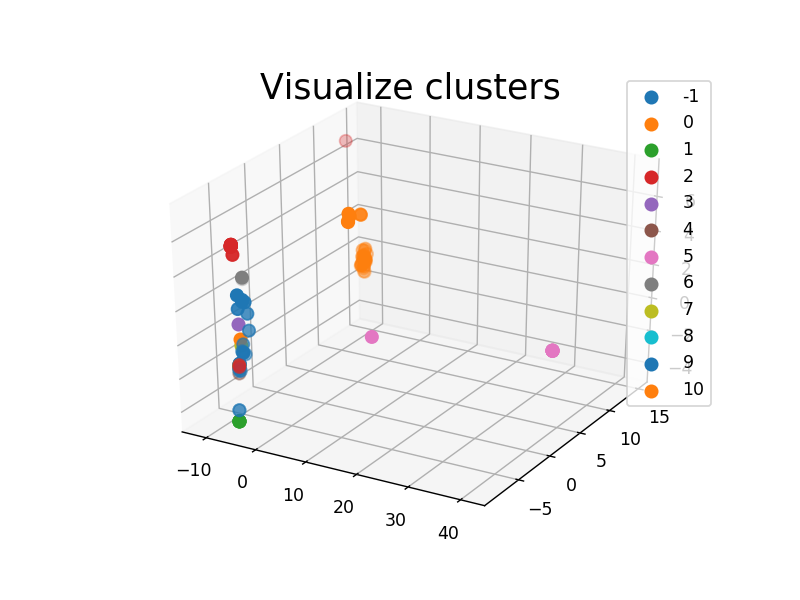

<IPython.core.display.Javascript object>


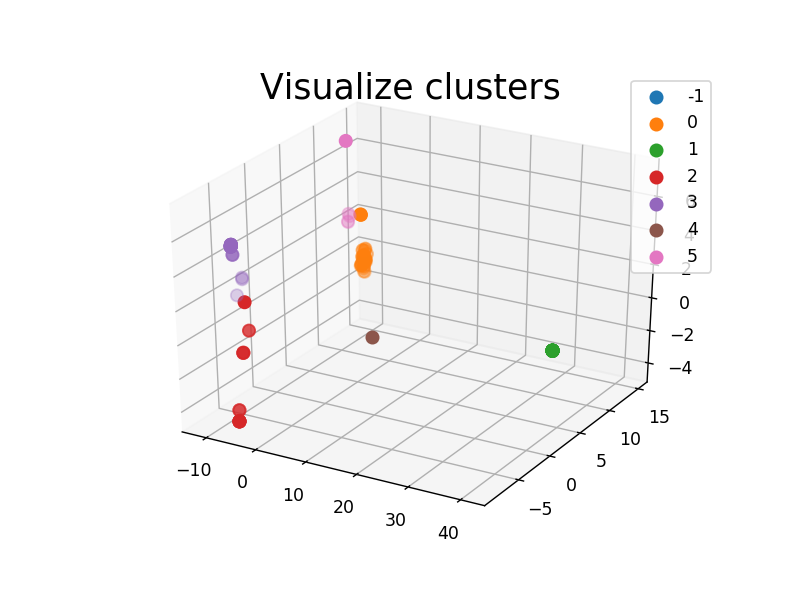

<IPython.core.display.Javascript object>


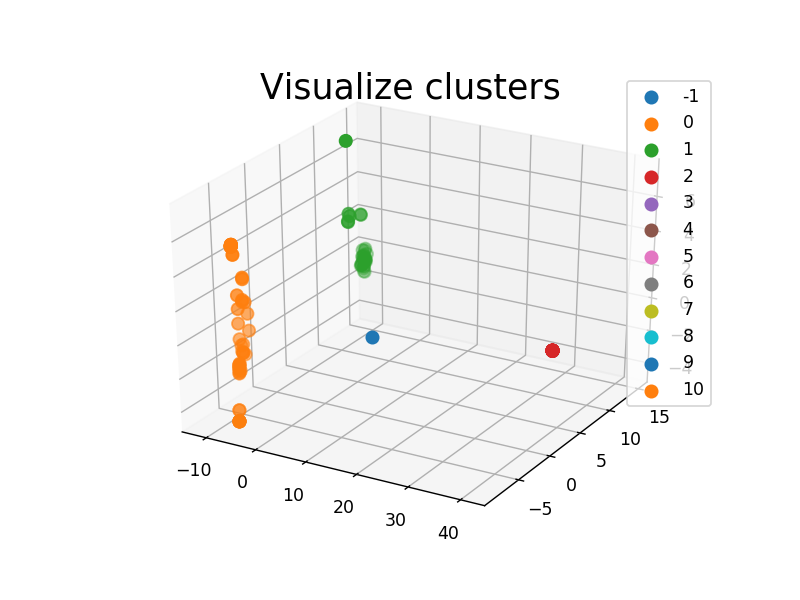

<IPython.core.display.Javascript object>


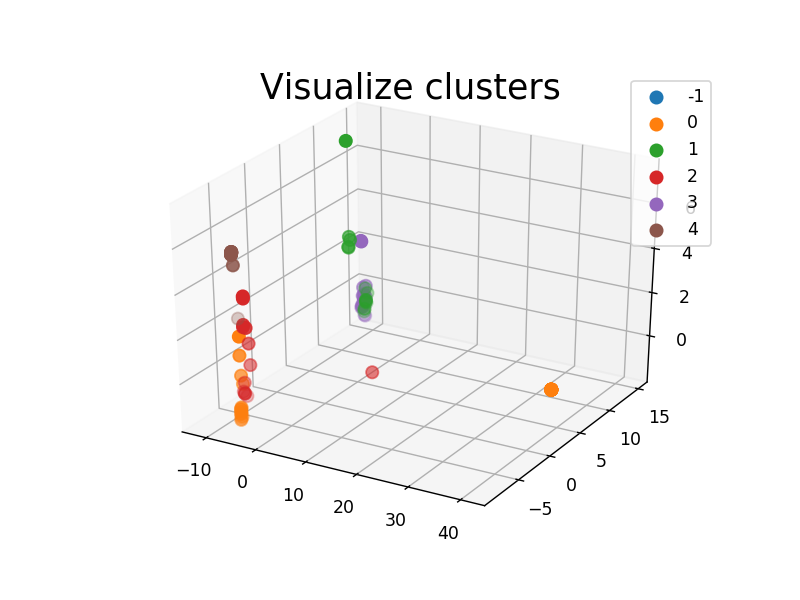

<IPython.core.display.Javascript object>


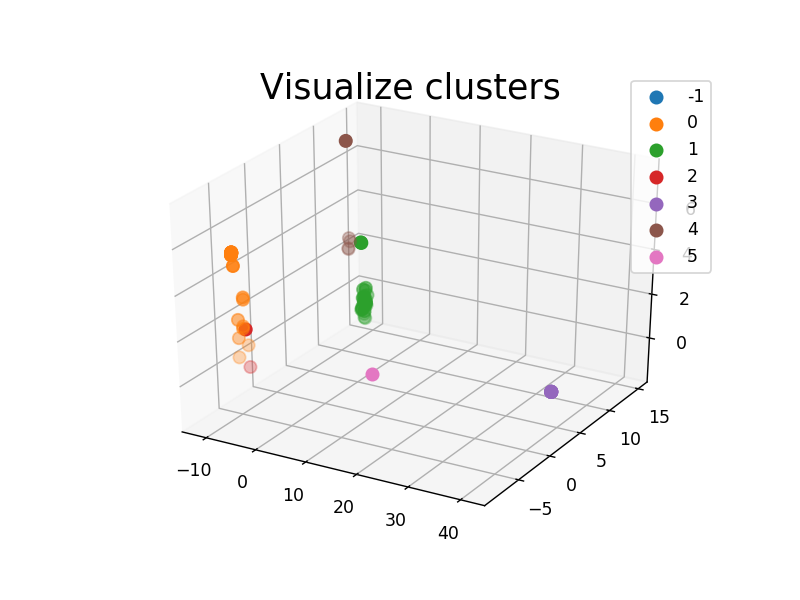

<IPython.core.display.Javascript object>


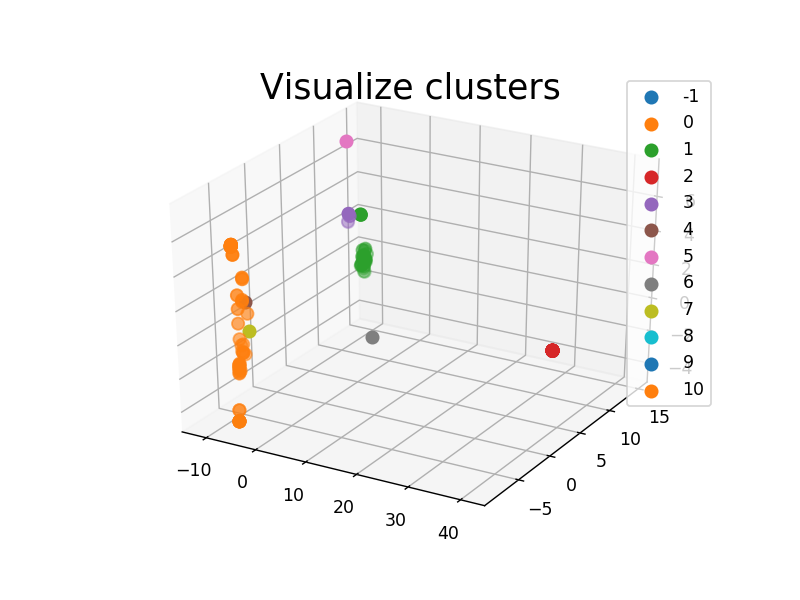

In [219]:
filepa = 'result/jupyter/'
visualize_result(finalDf, 12, filepa + 'real.png')
visualize_result(finalDf1, kmean_ncluster, filepa + 'kmeanplot.png')
visualize_result(finalDf2, 12, filepa + 'dbscanplot.png')
visualize_result(finalDf3, spectral_ncluster, filepa + 'spectralplot.png')
visualize_result(finalDf4, agglo_ncluster, filepa + 'aggroplot.png')
visualize_result(finalDf5, 12, filepa + 'meanshift.png')

In [220]:
def plot_cluster_to_bars(nclusters, viewname, filepath = None):
    for i in range(nclusters):
        filtered_data = view[view[viewname] == i]
        countedObjs = Counter(filtered_data['validation_groups'].values.tolist())
        objects = countedObjs.keys()
        y_pos = np.arange(len(objects))
        countOfAnObj = countedObjs.values()

        fig = plt.figure()
        fig.show()
        plt.bar(y_pos, countOfAnObj, align='center', alpha=0.5)
        plt.xticks(y_pos, objects)
        plt.ylabel('Count')
        plt.title('Clustering label' + str(i))
        if filepath == None:
            fig.show()
        else:
            filepath_splitted = filepath.rsplit('.',1)
            plt.savefig(filepath_splitted[0] + str(i) + '.' + filepath_splitted[1])

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


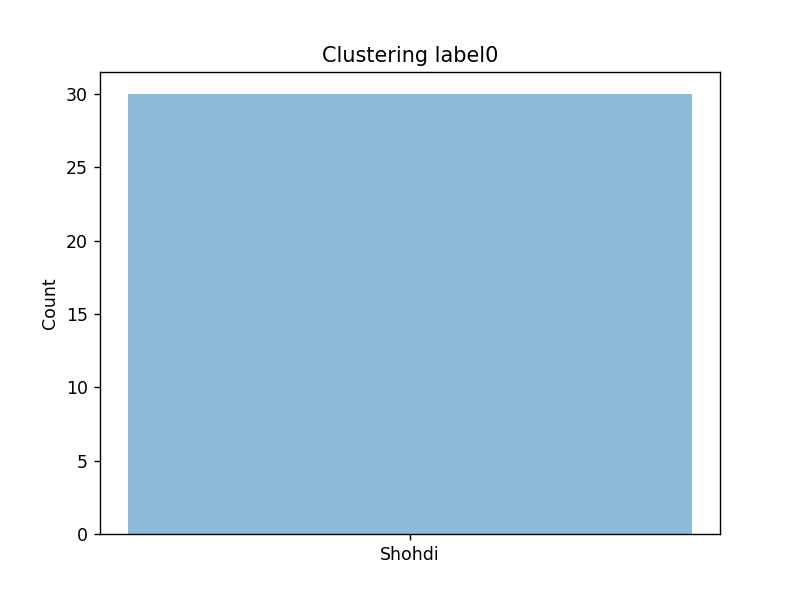

<IPython.core.display.Javascript object>


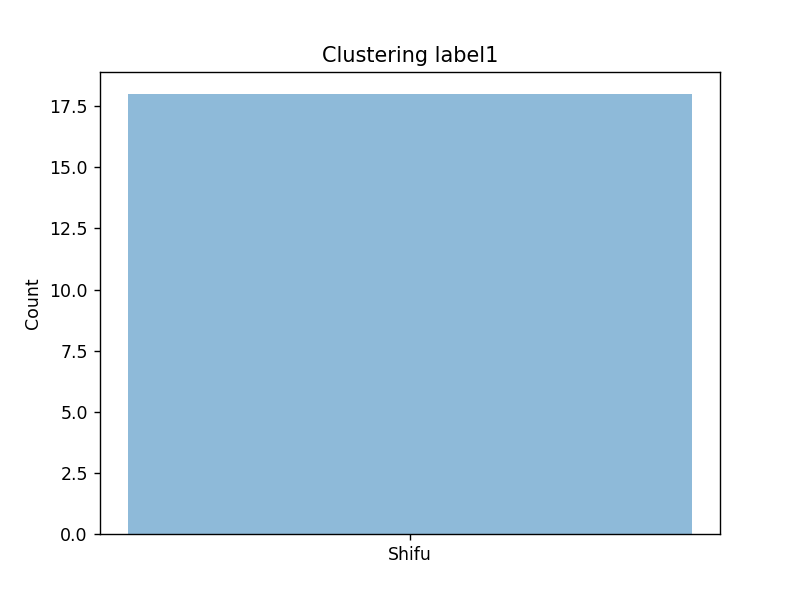

<IPython.core.display.Javascript object>


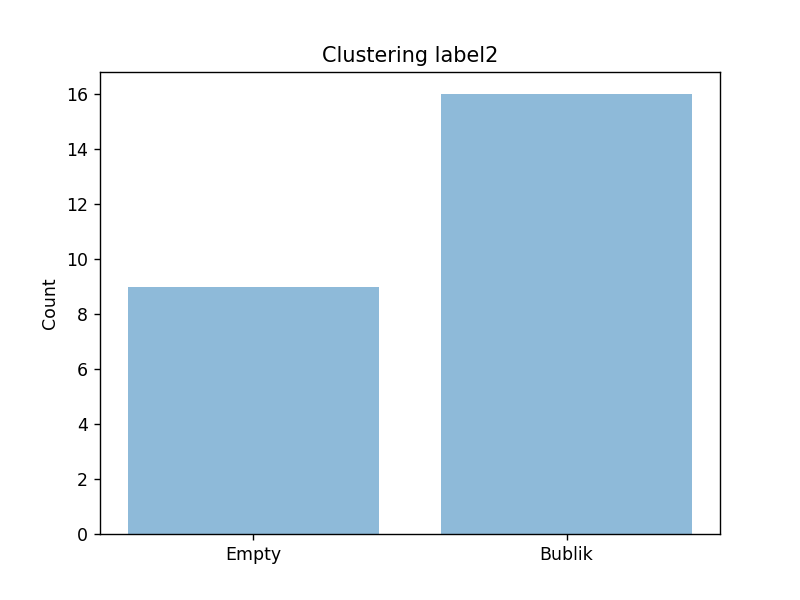

<IPython.core.display.Javascript object>


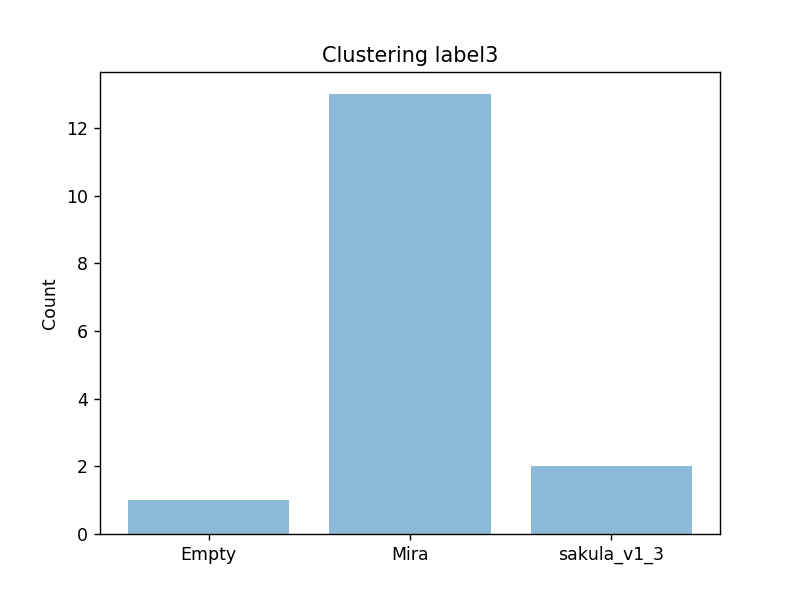

<IPython.core.display.Javascript object>


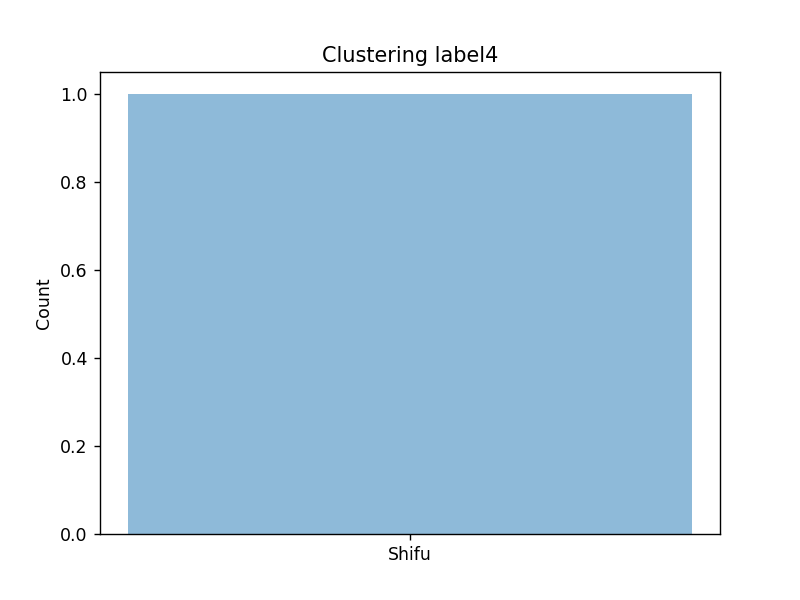

<IPython.core.display.Javascript object>


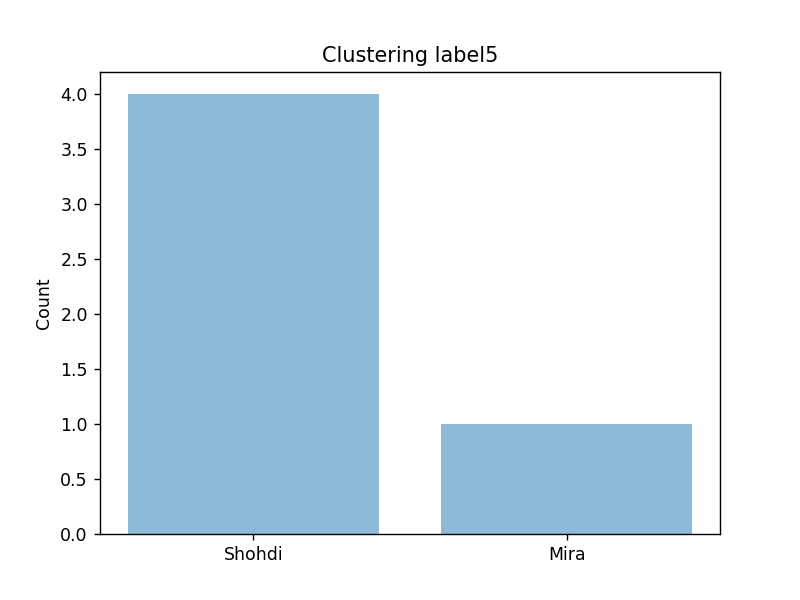

<IPython.core.display.Javascript object>


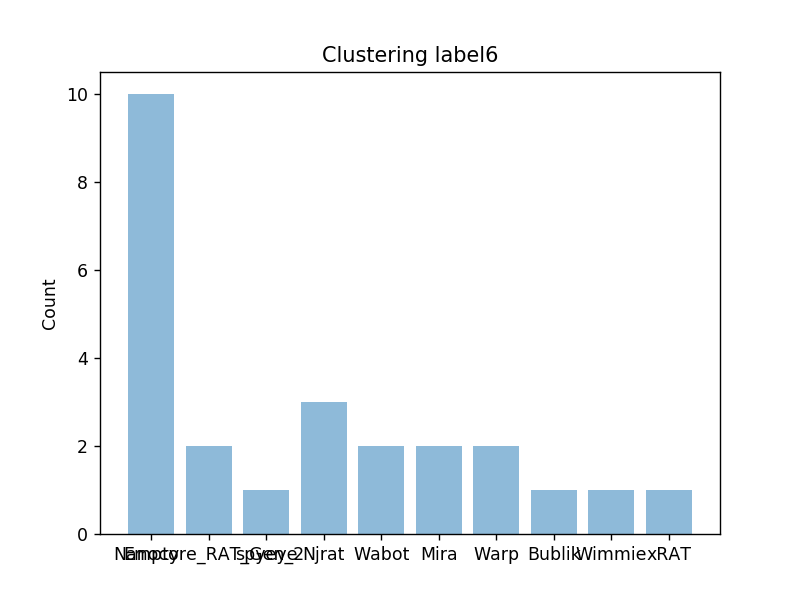

In [211]:
plot_cluster_to_bars(kmeans.n_clusters, 'kmeans', filepa + 'kmeansbar.png')

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


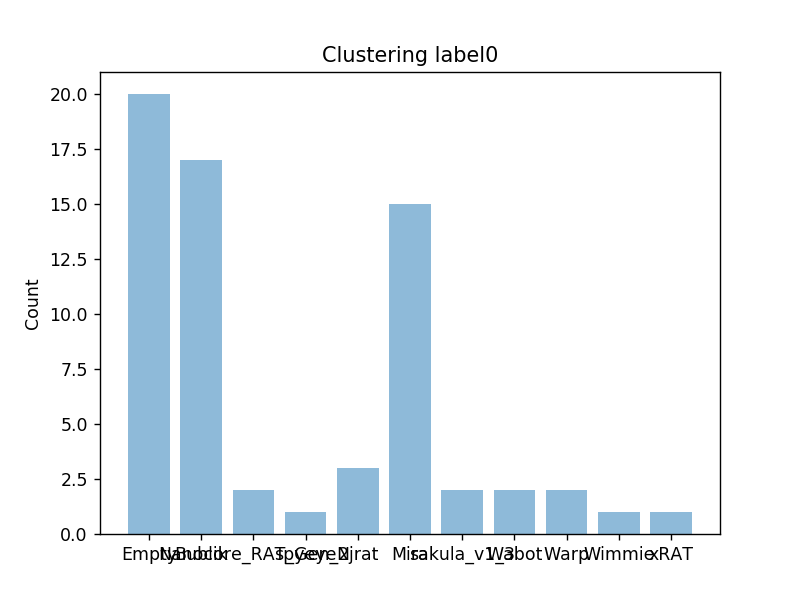

<IPython.core.display.Javascript object>


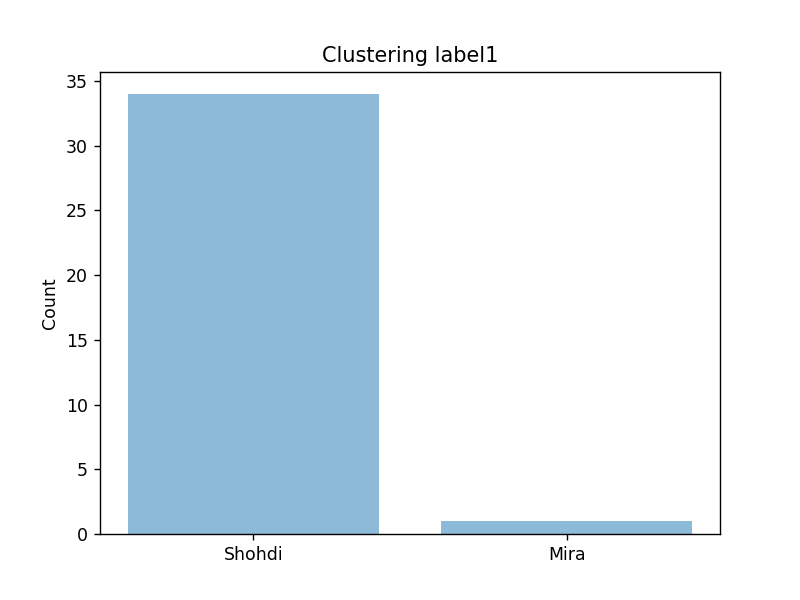

<IPython.core.display.Javascript object>


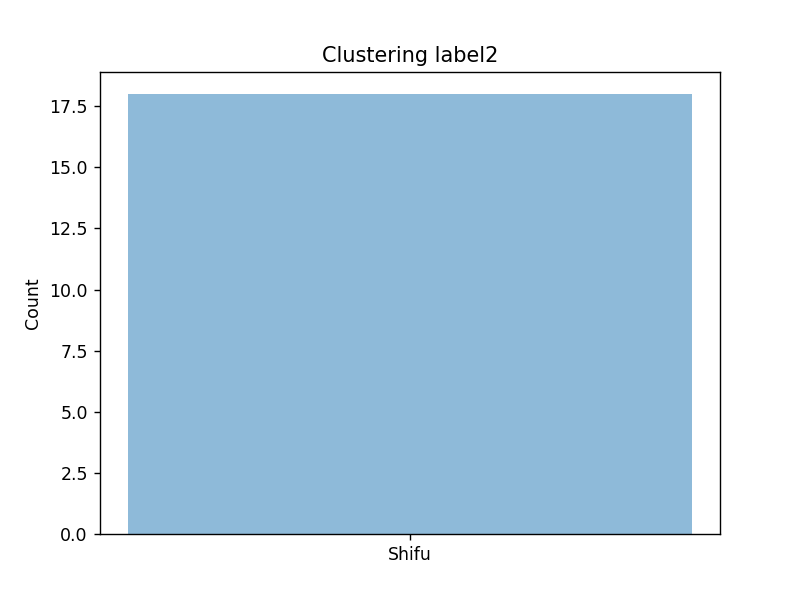

In [221]:
plot_cluster_to_bars( len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0), 'dbscan')

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


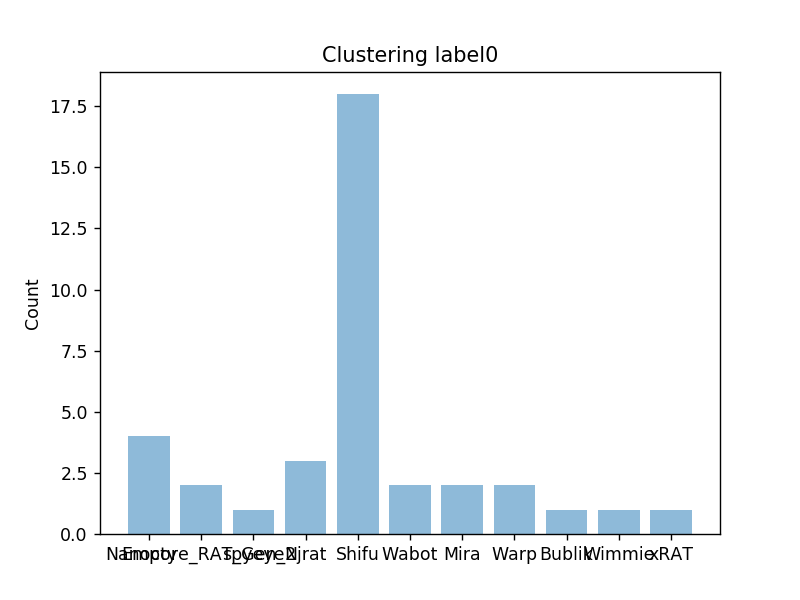

<IPython.core.display.Javascript object>


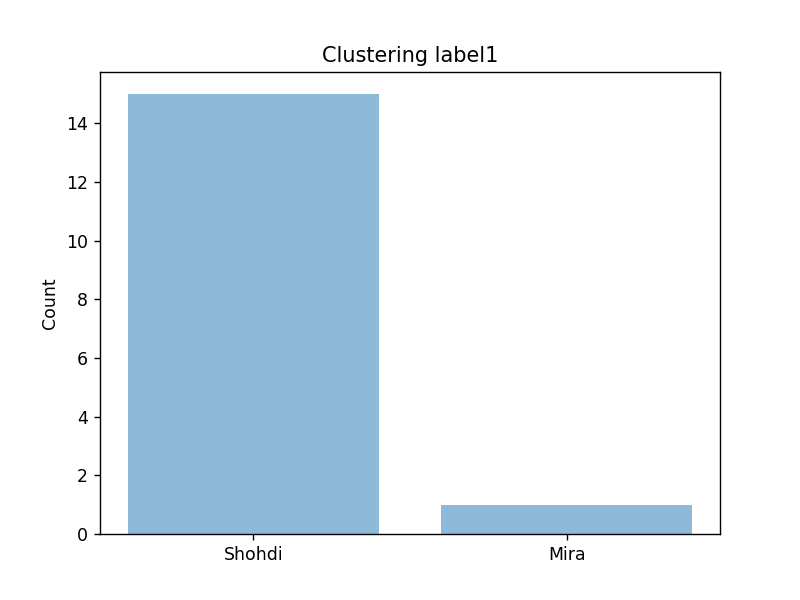

<IPython.core.display.Javascript object>


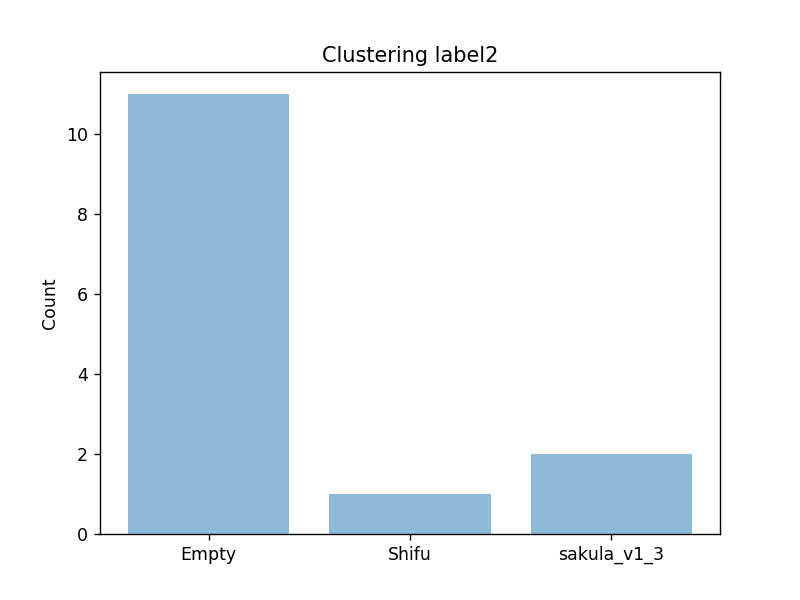

<IPython.core.display.Javascript object>


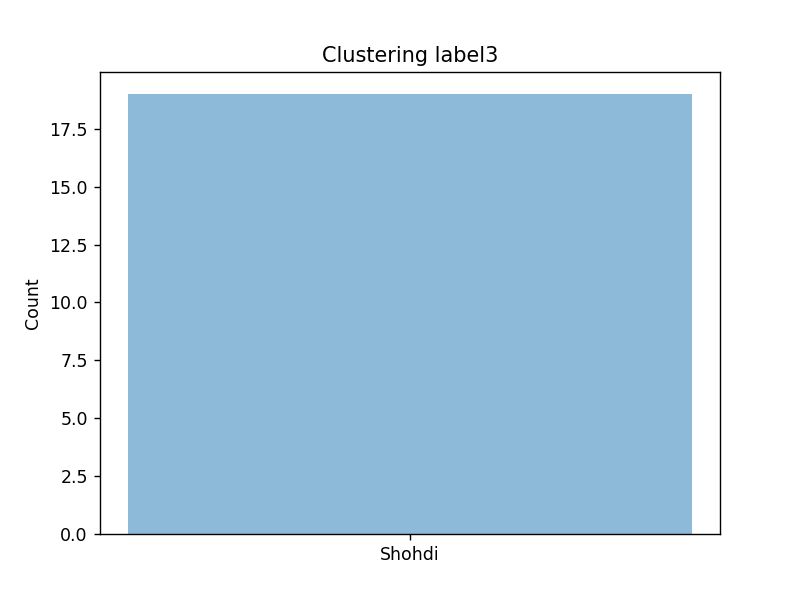

<IPython.core.display.Javascript object>


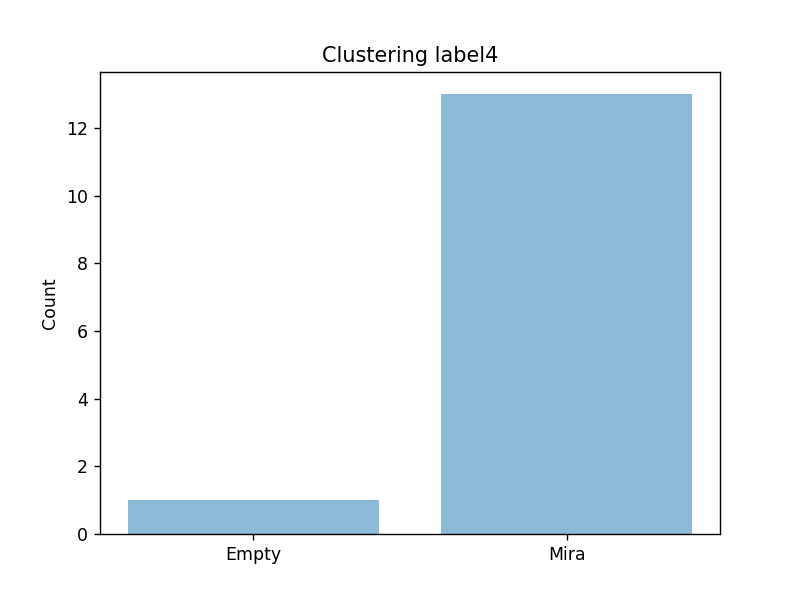

<IPython.core.display.Javascript object>


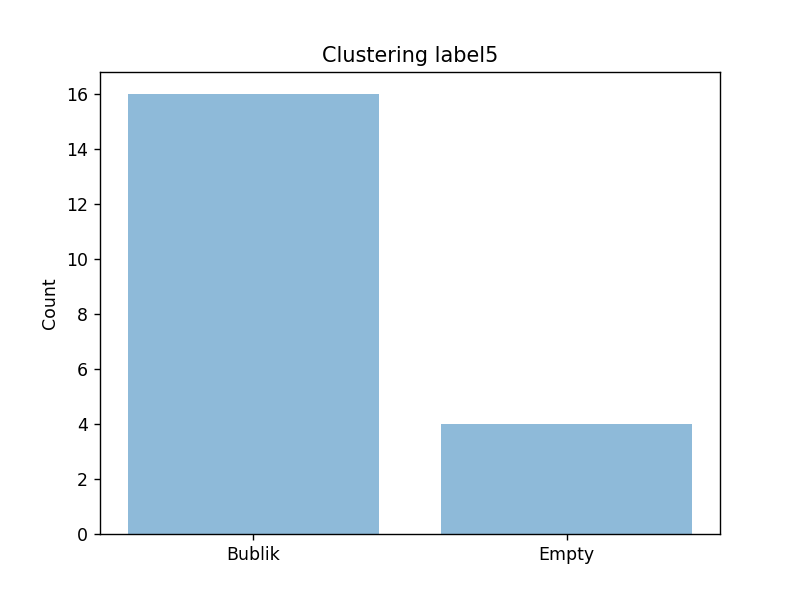

In [223]:
plot_cluster_to_bars(spectral.n_clusters, 'spectral_clustering', filepa + 'spectralbar.png')

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


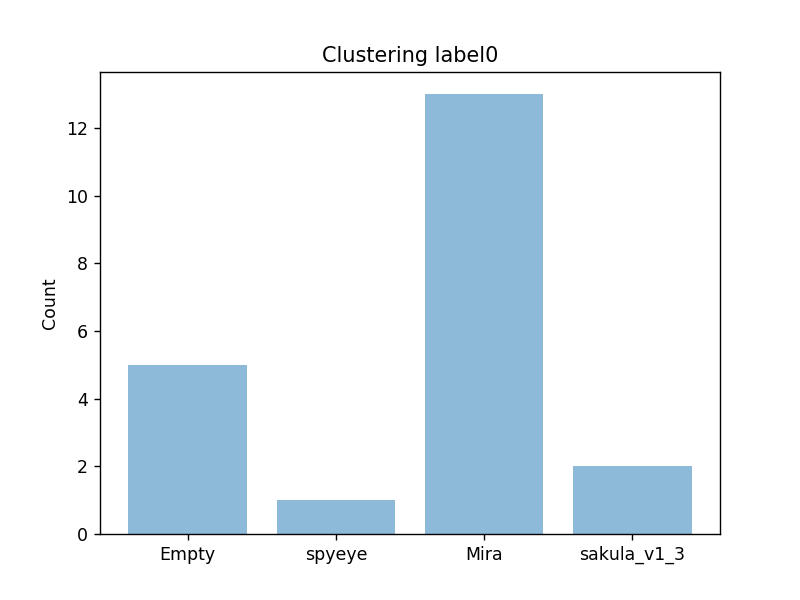

<IPython.core.display.Javascript object>


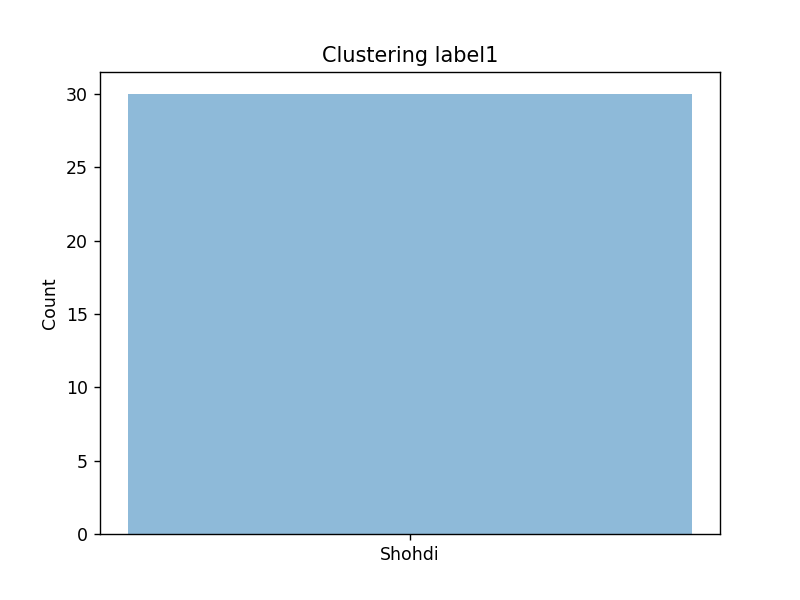

<IPython.core.display.Javascript object>


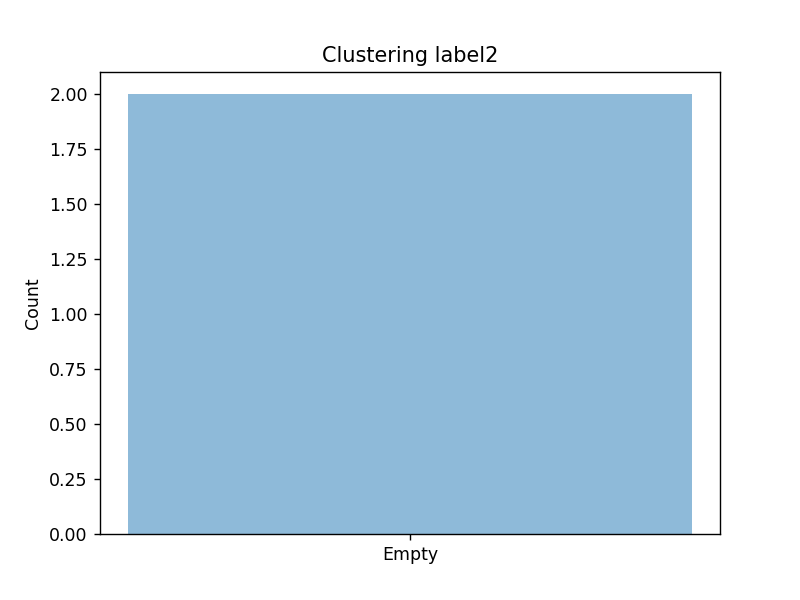

<IPython.core.display.Javascript object>


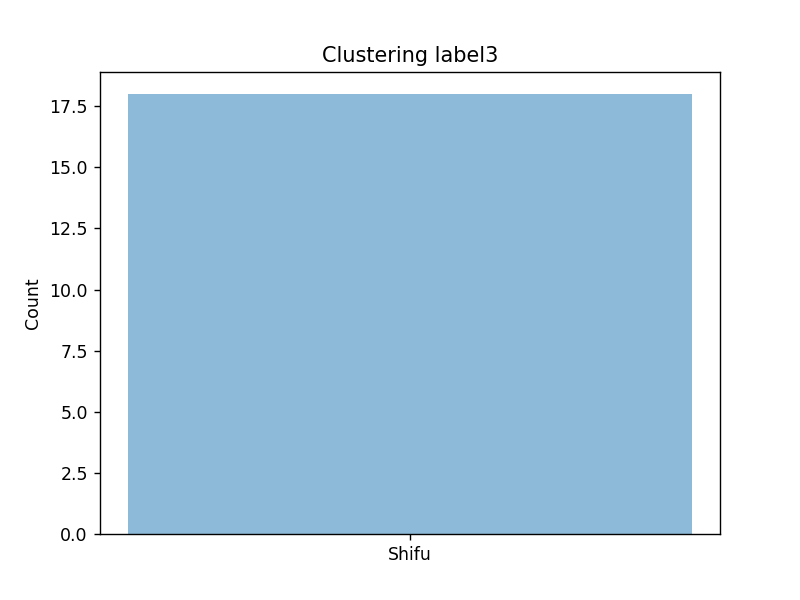

<IPython.core.display.Javascript object>


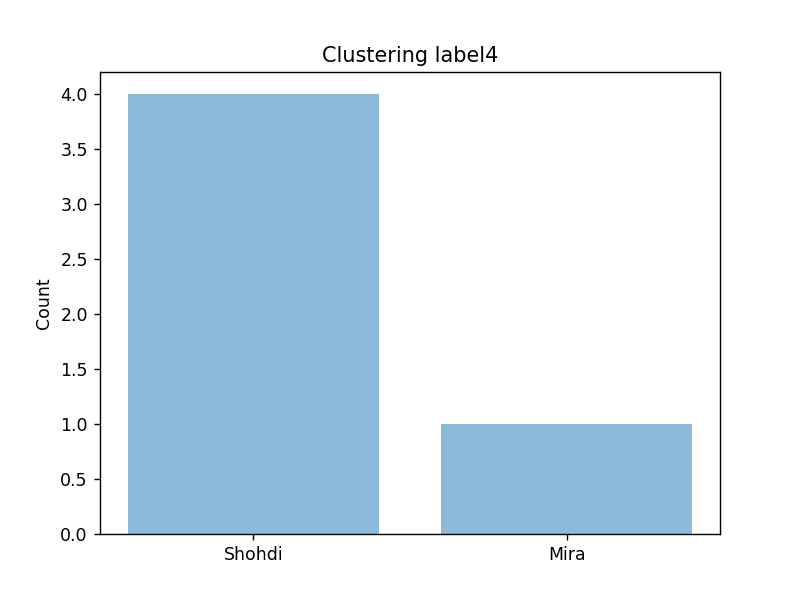

<IPython.core.display.Javascript object>


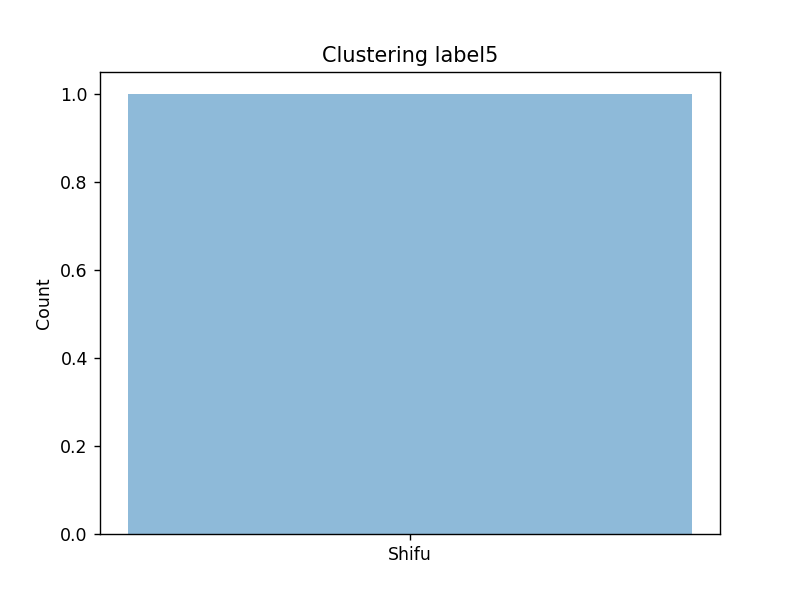

<IPython.core.display.Javascript object>


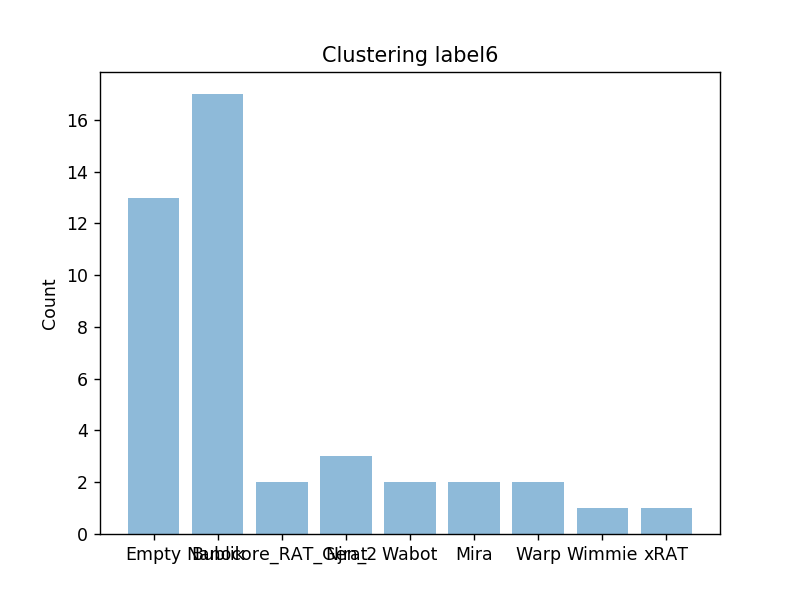

In [207]:
plot_cluster_to_bars(agglo.n_clusters, 'agglo')

O:\ProgrammingSoftwares\anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


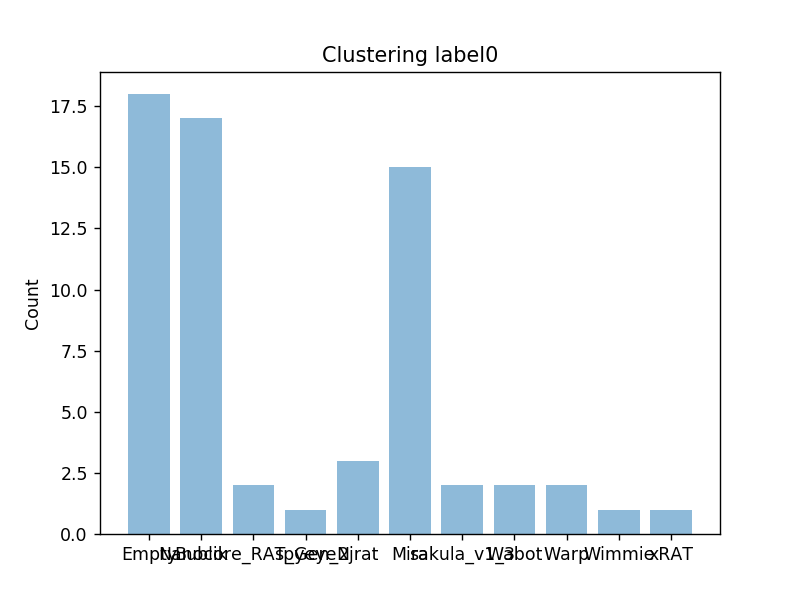

<IPython.core.display.Javascript object>


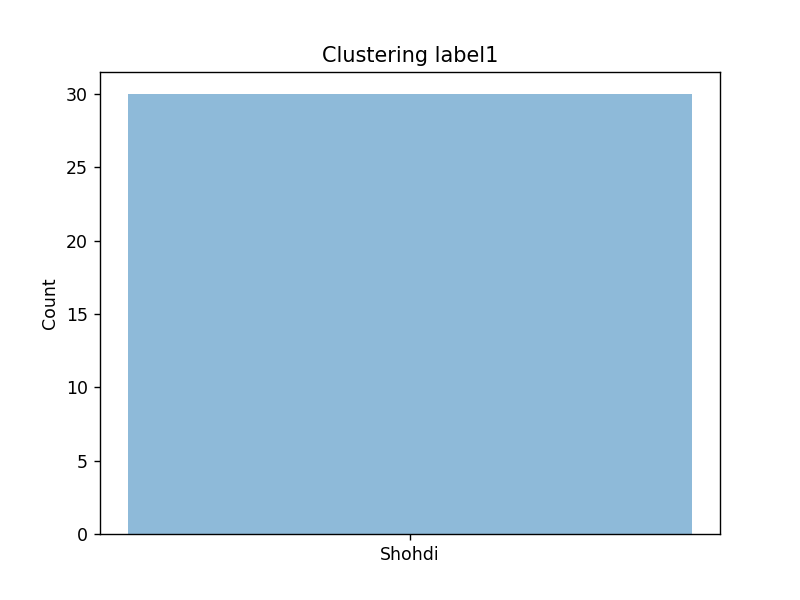

<IPython.core.display.Javascript object>


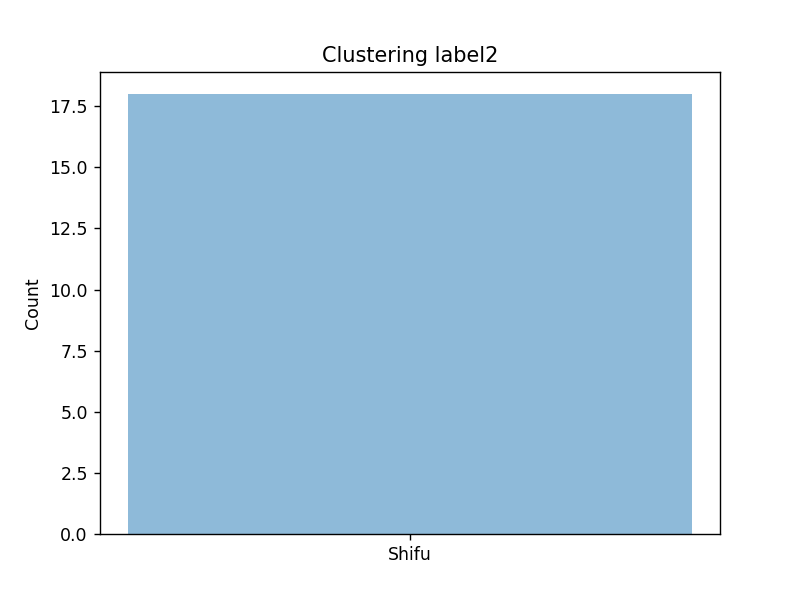

<IPython.core.display.Javascript object>


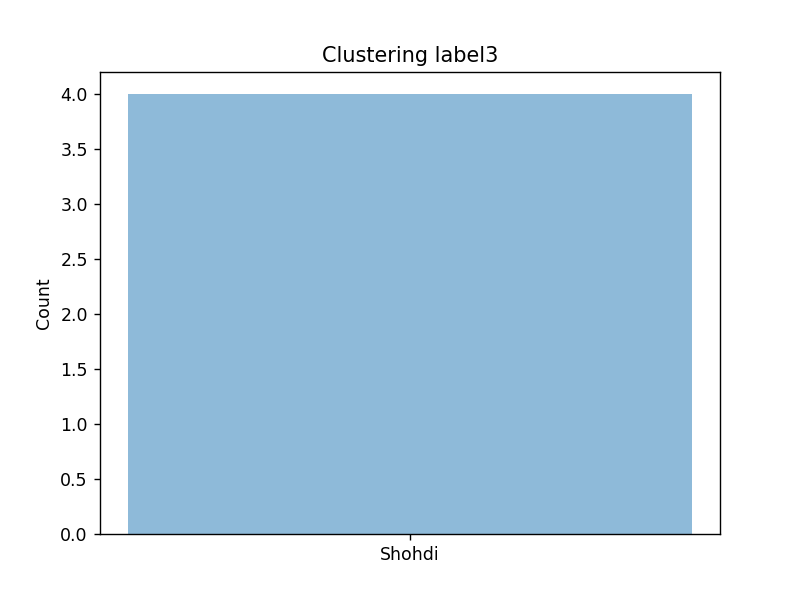

<IPython.core.display.Javascript object>


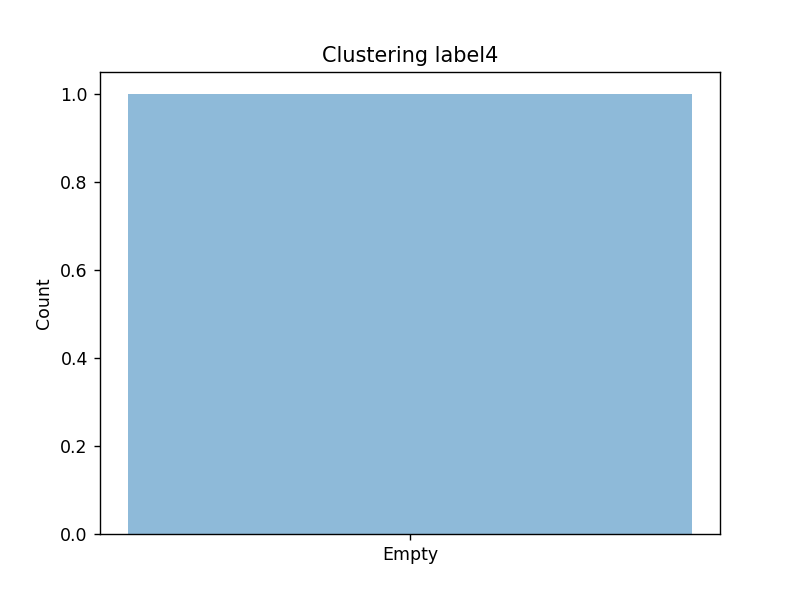

<IPython.core.display.Javascript object>


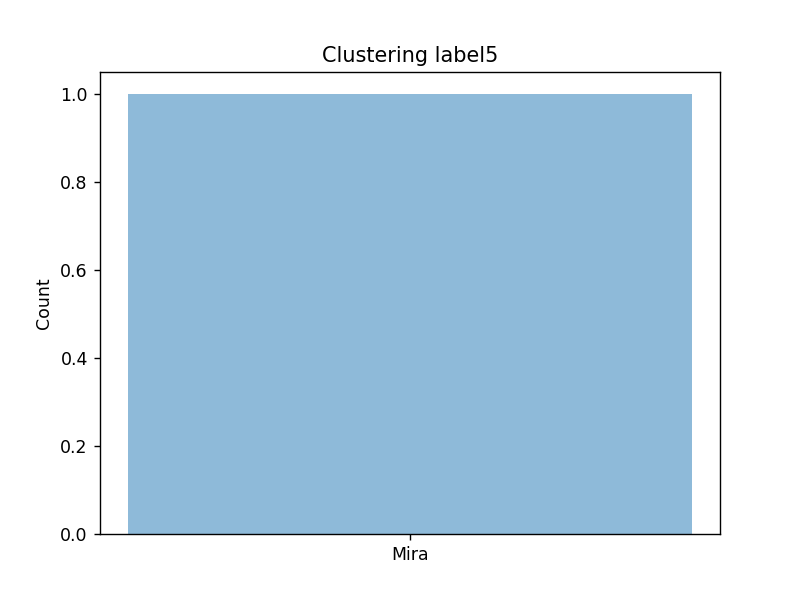

<IPython.core.display.Javascript object>


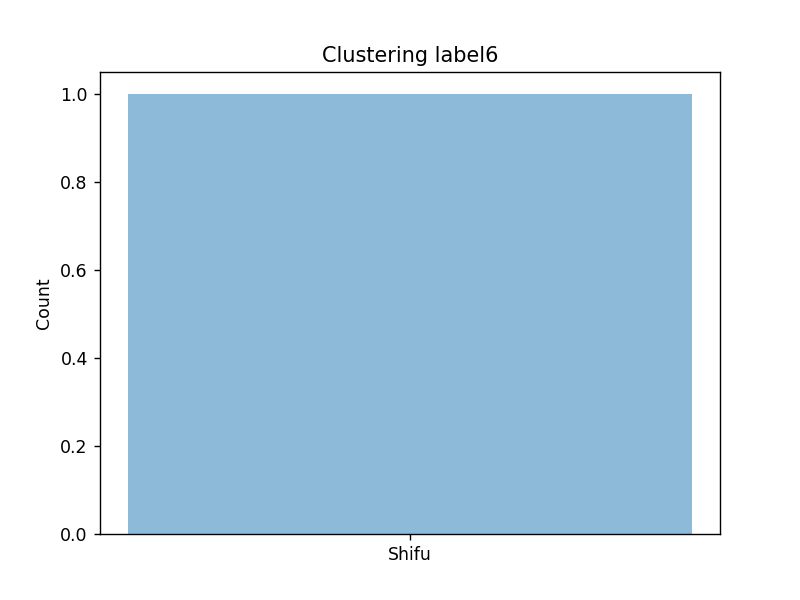

<IPython.core.display.Javascript object>


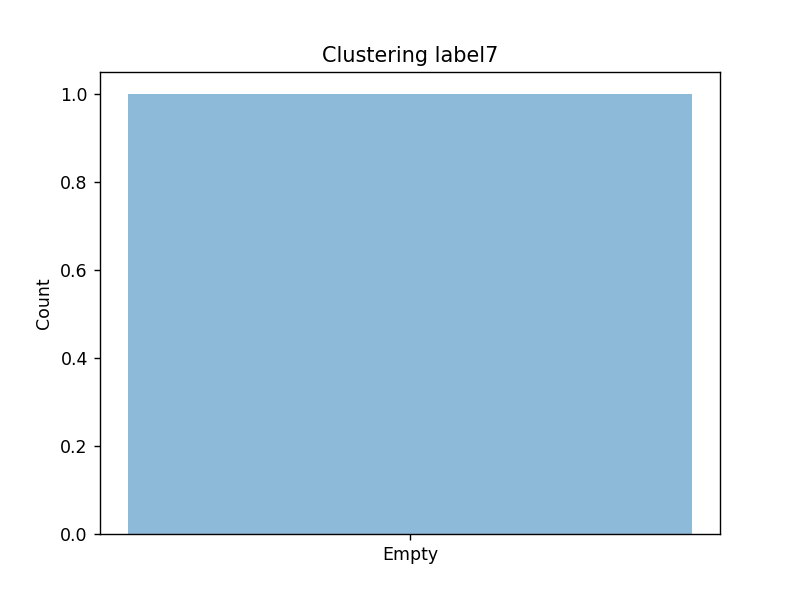

<IPython.core.display.Javascript object>


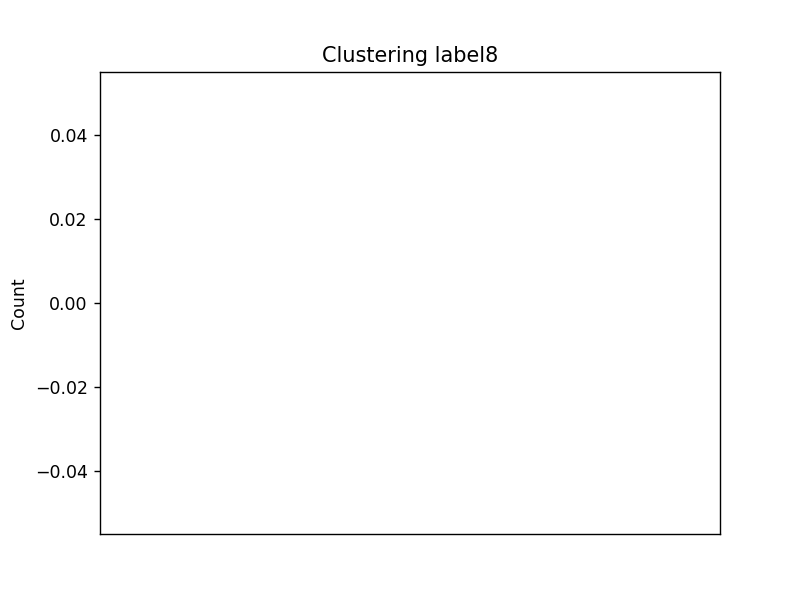

<IPython.core.display.Javascript object>


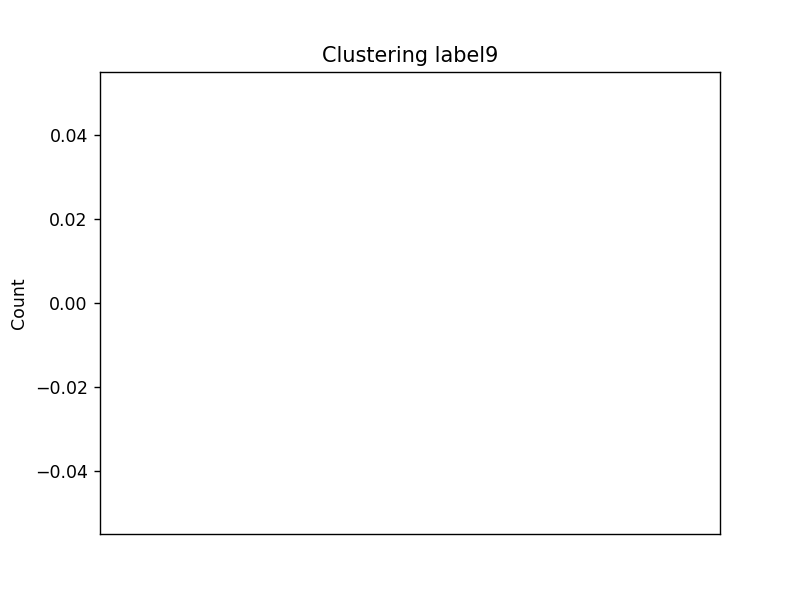

<IPython.core.display.Javascript object>


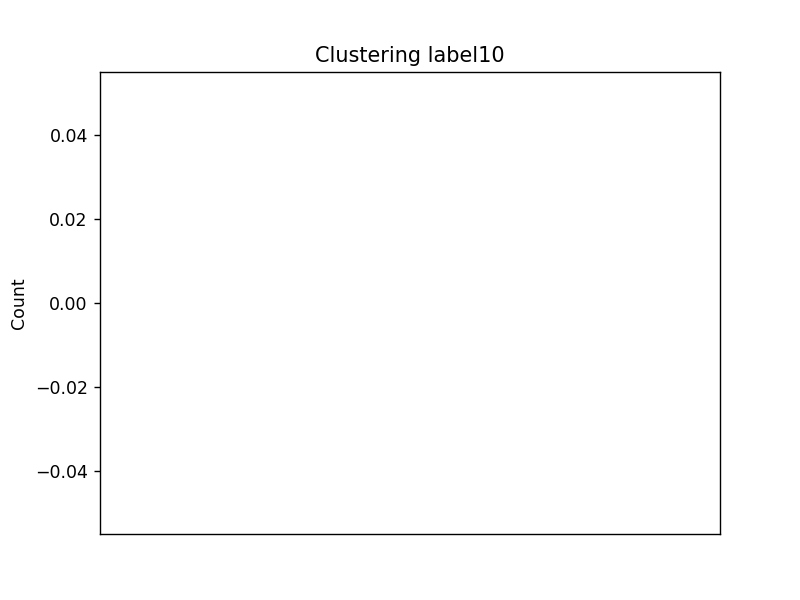

<IPython.core.display.Javascript object>


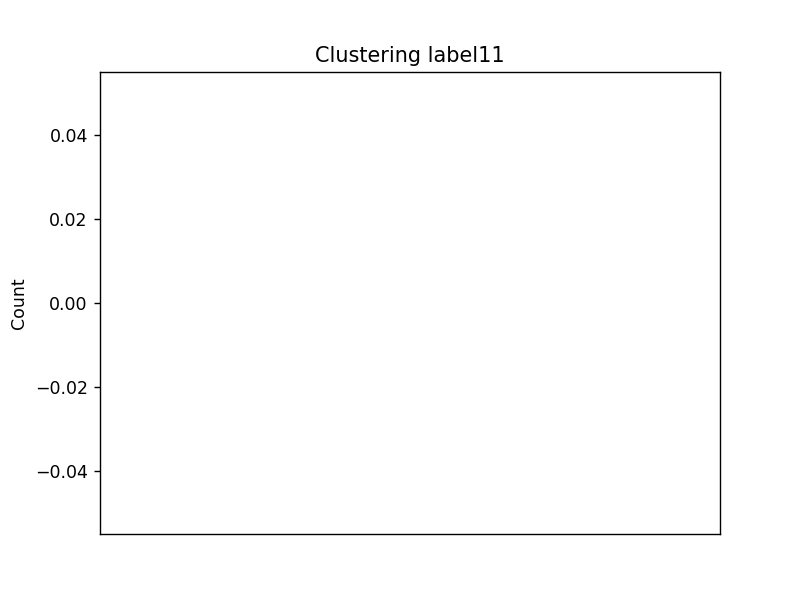

In [208]:
plot_cluster_to_bars(12, 'meanshift')